In [1]:
%pwd

'/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/notebooks'

In [2]:
%cd ..

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization


In [3]:
# Import the models so we can follow the training code
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torch.optim as optim

# Topology Library
import models
import problems
import topo_api
import topo_physics
import utils

%matplotlib inline

In [4]:
%cd pygranso

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/PyGRANSO


In [5]:
# first party
# Import pygranso functionality
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct
from pygranso.private.getNvar import getNvarTorch

# Running neural structural optimization with PyGranso 🧨

To check the validity of our new `torch` based code we will test the structural optimization with `torch.optim` optimizers.

### MBB Beam

The first problem that we will run is with the **MBB BEAM**.

In [6]:
def structural_optimization_function(model, ke, args, designs, debug=False):
    """
    Combined function for PyGranso for the structural optimization
    problem. The inputs will be the model that reparameterizes x as a function
    of a neural network. V0 is the initial volume, K is the global stiffness
    matrix and F is the forces that are applied in the problem.
    """
    # Initialize the model
    # In my version of the model it follows the similar behavior of the
    # tensorflow repository and only needs None to initialize and output
    # a first value of x
    logits = cnn_model(None)

    # kwargs for displacement
    kwargs = dict(
        penal=torch.tensor(args["penal"]),
        e_min=torch.tensor(args["young_min"]),
        e_0=torch.tensor(args["young"]),
    )

    # Calculate the physical density
    x_phys = topo_physics.physical_density(logits, args, volume_constraint=True)
    
    # Calculate the forces
    forces = topo_physics.calculate_forces(x_phys, args)
    
    # Calculate the u_matrix
    u_matrix = topo_physics.displace(
        x_phys, ke, forces, args['freedofs'], args['fixdofs'], **kwargs
    )
    
    # Calculate the compliance output
    compliance_output = topo_physics.compliance(x_phys, u_matrix, ke, **kwargs)
    
    # The loss is the sum of the compliance
    f = torch.sum(compliance_output)
    
    # Run this problem with no inequality constraints
    ci = None
    
    # Run this problem with no equality constraints
    ce = None
    
    designs.append(topo_physics.physical_density(logits, args, volume_constraint=True))
    
    return f, ci, ce

## PyGranso Initializations

This is where we will set up the problem and also the options to run pygranso

In [7]:
# Variable definitions
device = torch.device('cpu')
double_precision = torch.double

# Identify the problem
problem = problems.mbb_beam(height=20, width=60)

# Get the arguments for the problem
args = topo_api.specified_task(problem)

# Set up the cnn args for this problem
cnn_kwargs = dict(resizes=(1, 1, 2, 2, 1))

# Initialize the model
cnn_model = models.CNNModel(
    args=args,
    **cnn_kwargs
)

# Put the model in training mode
cnn_model.train()

# Get the stiffness matrix
ke = topo_physics.get_stiffness_matrix(
    young=args['young'], poisson=args['poisson'],
)

# Structural optimization problem setup
designs = []
comb_fn = lambda model: structural_optimization_function(
    model, ke, args, designs, debug=False
)

# PyGranso Options
opts = pygransoStruct()

# Set the device to CPU
opts.torch_device = device

# Set up the initial inputs to the solver
nvar = getNvarTorch(cnn_model.parameters())
opts.x0 = (
    torch.nn.utils.parameters_to_vector(cnn_model.parameters())
    .detach()
    .reshape(nvar, 1)
)

# Additional PyGranso options
opts.limited_mem_size = 20
opts.double_precision = True
opts.mu0 = 1.0
opts.maxit = 150
opts.print_frequency = 1
opts.stat_l2_model = False

# This was important to have the structural optimization solver converge
opts.init_step_size = 5e-6
opts.linesearch_maxit = 50

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/topo_api.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "forces": torch.tensor(problem.forces.ravel()),
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:67: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self.h = args["nely"] // total_resize
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/models.py:68: UserWarning: __floordiv__ is deprecated, and its behavior will change

In [8]:
# Run pygranso
start = time.time()
soln = pygranso(var_spec=cnn_model, combined_fn=comb_fn, user_opts=opts)
end = time.time()
print(f'Total wall time: {end - start}s')

/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_78446/1907579639.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_min=torch.tensor(args["young_min"]),
/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_78446/1907579639.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_0=torch.tensor(args["young"]),
/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/topo_physics.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_0 = torch.tensor(e_0)
/Users/ryandevera/data-science/tesorio/NCVX-Neura



╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

/Users/ryandevera/data-science/tesorio/NCVX-Neural-Structural-Optimization/PyGRANSO/pygranso/private/bfgsHessianInverseLimitedMem.py:237: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2985.)
  alpha[j,:]  = self.rho[0,j] * (self.S[:,j].T  @ q)


   2 ║  - │   -   ║  671.954569176 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.017127   ║ 
   3 ║  - │   -   ║  577.035945983 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.014555   ║ 
   4 ║  - │   -   ║  520.069251913 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.010647   ║ 
   5 ║  - │   -   ║  487.658559477 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.011061   ║ 
   6 ║  - │   -   ║  448.517768809 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.015220   ║ 
   7 ║  - │   -   ║  411.027947760 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.022279   ║ 
   8 ║  - │   -   ║  358.643683580 ║   -  │   -  ║ QN │    20 │ 2.621440 ║     1 │ 0.021844   ║ 
   9 ║  - │   -   ║  334.354571824 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.026626   ║ 
  10 ║  - │   -   ║  309.847340679 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.022053   ║ 
  11 ║  - │   -   ║  292.713349676 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.026555   ║ 
  12 ║  - │   -   ║  267.57059

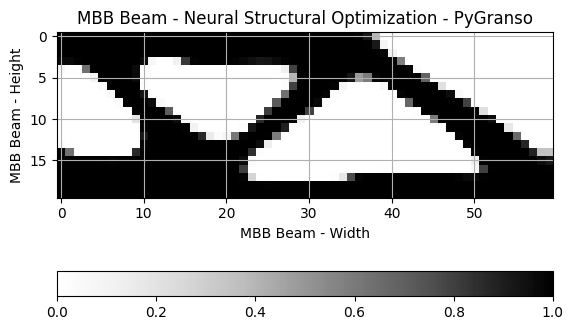

In [9]:
# Get the final frame
final_frame = designs[-1].detach().numpy()

# Create a figure and axis
fig, ax = plt.subplots(1, 1)

# Show the structure in grayscale
im = ax.imshow(final_frame, cmap='Greys')
ax.set_title('MBB Beam - Neural Structural Optimization - PyGranso')
ax.set_ylabel('MBB Beam - Height')
ax.set_xlabel('MBB Beam - Width')
ax.grid()
fig.colorbar(im, orientation="horizontal", pad=0.2)

# `PyGranso` Multi-story Building

In [10]:
# Variable definitions
device = torch.device('cpu')
double_precision = torch.double

# Identify the problem
problem = problems.PROBLEMS_BY_NAME['multistory_building_32x64_0.5']

# Get the arguments for the problem
args = topo_api.specified_task(problem)

# Initialize the model
cnn_model = models.CNNModel(
    args=args,
)

# Put the model in training mode
cnn_model.train()

# Get the stiffness matrix
ke = topo_physics.get_stiffness_matrix(
    young=args['young'], poisson=args['poisson'],
)

# Structural optimization problem setup
designs = []
comb_fn = lambda model: structural_optimization_function(
    model, ke, args, designs, debug=False
)

# PyGranso Options
opts = pygransoStruct()

# Set the device to CPU
opts.torch_device = device

# Set up the initial inputs to the solver
nvar = getNvarTorch(cnn_model.parameters())
opts.x0 = (
    torch.nn.utils.parameters_to_vector(cnn_model.parameters())
    .detach()
    .reshape(nvar, 1)
)

# Additional PyGranso options
opts.limited_mem_size = 20
opts.double_precision = True
opts.mu0 = 1.0
opts.maxit = 150
opts.print_frequency = 1
opts.stat_l2_model = False

# This was important to have the structural optimization solver converge
opts.init_step_size = 5e-6
opts.linesearch_maxit = 50

In [11]:
# Run pygranso
start = time.time()
soln = pygranso(var_spec=cnn_model, combined_fn=comb_fn, user_opts=opts)
end = time.time()
print(f'Total wall time: {end - start}s')

/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_78446/1907579639.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_min=torch.tensor(args["young_min"]),
/var/folders/6c/8rvpvzfs0vxbbx2jh4rbfb100000gn/T/ipykernel_78446/1907579639.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  e_0=torch.tensor(args["young"]),




╔═════ QP SOLVER NOTICE ════════════════════════════════════════════════════════════════════════╗
║  PyGRANSO requires a quadratic program (QP) solver that has a quadprog-compatible interface,  ║
║  the default is osqp. Users may provide their own wrapper for the QP solver.                  ║
║  To disable this notice, set opts.quadprog_info_msg = False                                   ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════╝
══════════════════════════════════════════════════════════════════════════════════════════════╗
PyGRANSO: A PyTorch-enabled port of GRANSO with auto-differentiation                          ║ 
Version 1.2.0                                                                                 ║ 
Licensed under the AGPLv3, Copyright (C) 2021-2022 Tim Mitchell and Buyun Liang               ║ 
══════════════════════════════════════════════════════════════════════════════════════════════╣
Problem specifications:  

  54 ║  - │   -   ║  49.8260665238 ║   -  │   -  ║ QN │    20 │ 2.621440 ║     1 │ 0.004131   ║ 
  55 ║  - │   -   ║  49.6649663714 ║   -  │   -  ║ QN │    20 │ 2.621440 ║     1 │ 0.026576   ║ 
  56 ║  - │   -   ║  49.4040087570 ║   -  │   -  ║ QN │    20 │ 2.621440 ║     1 │ 0.006265   ║ 
  57 ║  - │   -   ║  49.3016972877 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.004592   ║ 
  58 ║  - │   -   ║  49.2724294276 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.008210   ║ 
  59 ║  - │   -   ║  49.2512310635 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.006542   ║ 
═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
     ║ Penalty Fn ║                ║  Violation  ║ <--- Line Search ---> ║ <- Stationarity -> ║ 
Iter ║ Mu │ Value ║    Objective   ║ Ineq │  Eq  ║ SD │ Evals │     t    ║ Grads │    Value   ║ 
═════╬════════════╬════════════════╬═════════════╬═══════════════════════╬════════════════════╣
  60 ║  - │   -   ║  49.20849167

 123 ║  - │   -   ║  44.3818677576 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.015555   ║ 
 124 ║  - │   -   ║  44.3320957575 ║   -  │   -  ║ QN │    20 │ 2.621440 ║     1 │ 0.023744   ║ 
 125 ║  - │   -   ║  44.2916219805 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.051375   ║ 
 126 ║  - │   -   ║  44.2375218730 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.026404   ║ 
 127 ║  - │   -   ║  44.1848046243 ║   -  │   -  ║ QN │    20 │ 2.621440 ║     1 │ 0.061272   ║ 
 128 ║  - │   -   ║  44.1350638007 ║   -  │   -  ║ QN │    20 │ 2.621440 ║     1 │ 0.013494   ║ 
 129 ║  - │   -   ║  44.1007294212 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.028383   ║ 
 130 ║  - │   -   ║  44.0797301652 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.027683   ║ 
 131 ║  - │   -   ║  44.0580384852 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.047017   ║ 
 132 ║  - │   -   ║  44.0315641782 ║   -  │   -  ║ QN │    19 │ 1.310720 ║     1 │ 0.004895   ║ 
 133 ║  - │   -   ║  43.967790

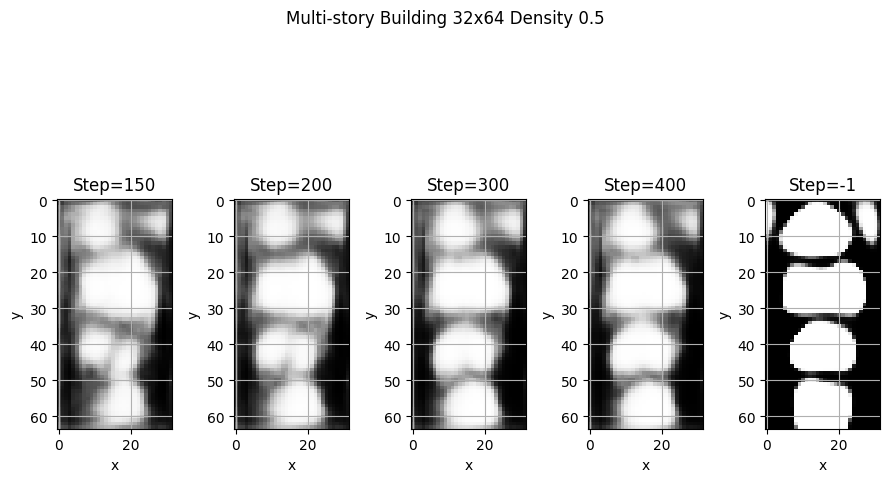

In [22]:
# # Get the final frames
frames = [150, 200, 300, 400, -1]

# Create a figure and axis
fig, axes = plt.subplots(1, 5, figsize=(9, 6))
axes = axes.flatten()

for idx, frames in enumerate(frames):
    # Show the structure in grayscale
    im = axes[idx].imshow(designs[frames].detach().numpy(), cmap='Greys')
    axes[idx].set_ylabel('y')
    axes[idx].set_xlabel('x')
    axes[idx].grid()
    axes[idx].set_title(f'Step={frames}')
    
plt.suptitle('Multi-story Building 32x64 Density 0.5')
fig.tight_layout()